In [54]:
from src.config import PretrainedConfig
from src.antispoof_predict import AntiSpoofPretrained
from torchsummary import summary
import torch
import onnx
import onnxruntime

In [64]:
cnf = PretrainedConfig('saved_models/AntiSpoofing_print-replay_128.pth',
                       num_classes=3)
model = AntiSpoofPretrained(cnf).model
summary(model);

Layer (type:depth-idx)                   Param #
├─Conv_block: 1-1                        --
|    └─Conv2d: 2-1                       864
|    └─BatchNorm2d: 2-2                  64
|    └─PReLU: 2-3                        32
├─Conv_block: 1-2                        --
|    └─Conv2d: 2-4                       288
|    └─BatchNorm2d: 2-5                  64
|    └─PReLU: 2-6                        32
├─Depth_Wise: 1-3                        --
|    └─Conv_block: 2-7                   --
|    |    └─Conv2d: 3-1                  3,296
|    |    └─BatchNorm2d: 3-2             206
|    |    └─PReLU: 3-3                   103
|    └─Conv_block: 2-8                   --
|    |    └─Conv2d: 3-4                  927
|    |    └─BatchNorm2d: 3-5             206
|    |    └─PReLU: 3-6                   103
|    └─Linear_block: 2-9                 --
|    |    └─Conv2d: 3-7                  6,592
|    |    └─BatchNorm2d: 3-8             128
├─ResidualSE: 1-4                        --
|    └─Sequen

In [65]:
onnx_model_path = cnf.model_path.replace('.pth','.onnx')

model.eval()
dummy_input = torch.randn(1, 3, cnf.input_size, cnf.input_size).to(cnf.device)
torch.onnx.export(model, 
                  dummy_input,
                  onnx_model_path,
                  #verbose=False,
                  input_names=['input'],
                  output_names=['output'],
                  export_params=True,
                 )
print('ONNX model exported')

# load onnx model
onnx_model = onnx.load(onnx_model_path)  
# Check the model
try:
    onnx.checker.check_model(onnx_model)
except onnx.checker.ValidationError as e:
    print('The model is invalid: %s' % e)
else:
    print('The model is valid!')

ONNX model exported
The model is valid!


In [66]:
session = onnxruntime.InferenceSession(
    onnx_model_path, providers=['CUDAExecutionProvider', 'CPUExecutionProvider'])

onnxruntime.get_device()

'GPU'

In [67]:
print(onnx_model.ir_version)

4


In [68]:
input_name = session.get_inputs()[0].name
output_name = session.get_outputs()[0].name

input_name, output_name

('input', 'output')

In [80]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
img0_path = "CelebA_Spoof_crop/data128/test/4930/live/494536.png"
img1_path = "CelebA_Spoof_crop/data128/test/4930/spoof/495600.png"

def preprocessing(img, new_size=128):
    old_size = img.shape[:2] # old_size is in (height, width) format

    ratio = float(new_size)/max(old_size)
    new_shape = tuple([int(x*ratio) for x in old_size])

    # new_size should be in (width, height) format
    img = cv2.resize(img, (new_shape[1], new_shape[0]))

    delta_w = new_size - new_shape[1]
    delta_h = new_size - new_shape[0]
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)

    img = cv2.copyMakeBorder(img, top, bottom, left, right, 
                              cv2.BORDER_CONSTANT, value=[0, 0, 0])
    img = img.transpose(2, 0, 1).astype(np.float32) / 255.0
    img = np.expand_dims(img, axis=0)
    return img

def softmax(x):
    return np.exp(x)/np.sum(np.exp(x))

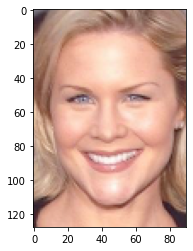

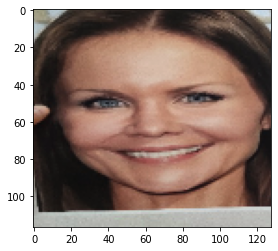

((1, 3, 128, 128), (1, 3, 128, 128))

In [70]:
img0 = cv2.cvtColor(cv2.imread(img0_path), cv2.COLOR_BGR2RGB)
plt.imshow(img0)
plt.show()
img0 = preprocessing(img0)


img1 = cv2.cvtColor(cv2.imread(img1_path), cv2.COLOR_BGR2RGB)
plt.imshow(img1)
plt.show()
img1 = preprocessing(img1)

img0.shape, img1.shape

In [81]:
pred0 = session.run([], {input_name: img0})
softmax(pred0)

array([[[9.9974763e-01, 2.0644304e-04, 4.5913403e-05]]], dtype=float32)

In [82]:
pred1 = session.run([], {input_name: img1})
softmax(pred1)

array([[[7.8910351e-05, 9.3893552e-01, 6.0985573e-02]]], dtype=float32)